In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
_UNIT_SCALE = {
    "s": 1.0, "sec": 1.0, "seconds": 1.0,
    "ms": 1e-3, "us": 1e-6, "µs": 1e-6, "μs": 1e-6, "ns": 1e-9,
    "v": 1.0, "mv": 1e-3
}

def _scale_for(unit_text: str) -> float:
    u = unit_text.strip().strip("()").lower()
    if u not in _UNIT_SCALE:
        raise ValueError(f"Unrecognized unit '{unit_text}'")
    return _UNIT_SCALE[u]

def load_scope_csv_with_units(path):
    """
    Expects first line = column names, second line = units.
    Returns time in seconds, Channel A in volts, Channel B in volts.
    """
    with open(path, "r") as f:
        name_line  = f.readline().strip()
        unit_line  = f.readline().strip()
        # Load the rest as numeric
        data = np.loadtxt(f, delimiter=",")

    names = [s.strip() for s in name_line.split(",")]
    units = [s.strip() for s in unit_line.split(",")]
    if len(names) < 2 or len(units) != len(names):
        raise ValueError("Header must have a names line and a matching units line.")

    # Map columns
    try:
        t_col = names.index("Time")
    except ValueError:
        raise ValueError(f"'Time' column not found in names: {names}")

    # Channel names can vary slightly; fall back to positional if needed
    def find_col(candidates, default_idx):
        for cand in candidates:
            if cand in names:
                return names.index(cand)
        return default_idx if default_idx < data.shape[1] else None

    a_col = find_col(["Channel A", "A", "ChA"], 1)
    b_col = find_col(["Channel B", "B", "ChB"], 2)

    # Unit scales
    t_scale = _scale_for(units[t_col])
    a_scale = _scale_for(units[a_col]) if a_col is not None else None
    b_scale = _scale_for(units[b_col]) if b_col is not None else None

    # Convert
    t  = data[:, t_col] * t_scale
    chA = data[:, a_col] * a_scale if a_col is not None else None
    chB = data[:, b_col] * b_scale if b_col is not None else None

    return t, chA, chB


In [3]:
t, chA, chB = load_scope_csv_with_units("AmpPhaseModData.csv")
# In your sample: Time is (us) → seconds, Channel A is (mV) → volts, Channel B is already volts.
# Pick whichever channel has your microwave trace:
v = chA
v_ref = chB

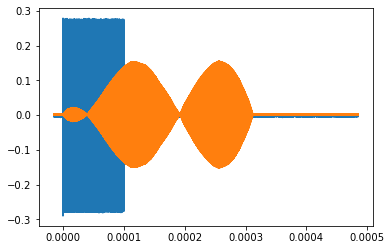

In [4]:
fig,ax = plt.subplots()
ax.plot(t,v_ref)
ax.plot(t,v)
plt.show()

In [5]:
# Extract reference frequency

def estimate_fc_from_ref_fft(t_us: np.ndarray, y: np.ndarray) -> float:
    """
    Estimate carrier frequency from FFT peak (with parabolic interpolation).
    t_us : time vector in microseconds
    y    : reference channel samples
    returns fc in Hz
    """
    t = np.asarray(t_us, float) * 1e-6
    y = np.asarray(y, float) - np.mean(y)
    fs = 1.0 / np.median(np.diff(t))

    w = np.hanning(y.size)
    Y = np.fft.rfft(y*w)
    freqs = np.fft.rfftfreq(y.size, d=1/fs)
    k = int(np.argmax(np.abs(Y)))

    # quadratic (parabolic) interpolation around the magnitude peak
    if 1 <= k < len(Y)-1:
        a = np.abs(Y[k-1]); b = np.abs(Y[k]); c = np.abs(Y[k+1])
        denom = (a - 2*b + c)
        delta = 0.5*(a - c)/denom if denom != 0 else 0.0
        fc = (k + delta) * fs / (2*(len(Y)-1)) * 2  # or simply: freqs[k] + delta*(freqs[1]-freqs[0])
        # Easier/clearer:
        fc = freqs[k] + delta*(freqs[1]-freqs[0])
    else:
        fc = freqs[k]
    return float(fc)

est_fc = estimate_fc_from_ref_fft(t*1e6,v_ref)
print(est_fc)

5999854.0965821855


In [6]:
def iq_demod_known_fc(t, v, f_c, lp_cutoff, numtaps=401):
    """
    t: time array (s), uniformly sampled (or very close)
    v: voltage array
    f_c: carrier (Hz)
    lp_cutoff: low-pass cutoff (Hz), > modulation BW, << f_c
    returns: I, Q, amplitude, phase (rad), inst_freq (Hz)
    """
    # sampling
    dt = np.median(np.diff(t))
    fs = 1.0/dt

    # remove DC
    v = v - np.mean(v)

    # reference sinusoids
    c = np.cos(2*np.pi*f_c*t)
    s = np.sin(2*np.pi*f_c*t)

    # mix down (factor 2 puts I/Q near A(t) scale)
    I_raw = 2.0 * v * c
    Q_raw = -2.0 * v * s

    # linear-phase lowpass (zero-phase via filtfilt to avoid group delay)
    b = signal.firwin(numtaps, lp_cutoff, fs=fs)
    I = signal.filtfilt(b, [1.0], I_raw)
    Q = signal.filtfilt(b, [1.0], Q_raw)

    amp  = np.hypot(I, Q)
    phase = np.arctan2(Q, I)
    finst = np.gradient(phase, t) / (2*np.pi)
    return I, Q, amp, phase, finst, fs

In [7]:
I, Q, A, phi, finst, fs = iq_demod_known_fc(t, v, f_c=est_fc, lp_cutoff=5e3)

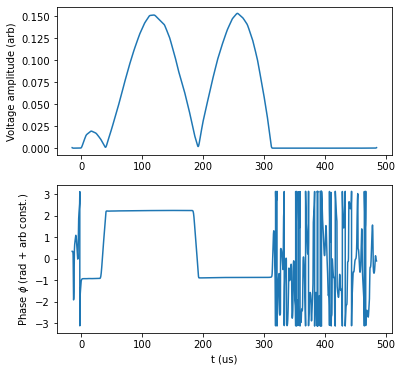

In [11]:
fig,(axA,axPhi) = plt.subplots(2,figsize=(6,6))
axA.plot(t*1e6,A)
axPhi.plot(t*1e6,phi)
# ax.plot(t,phi)
# axPhi.im(-np.pi,np.pi)
axPhi.set_xlabel('t (us)')
axA.set_ylabel('Voltage amplitude (arb)')
axPhi.set_ylabel('Phase $\phi$ (rad + arb const.)')

plt.show()